### Explore nuScenes Maps

In [1]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from PIL import Image
from shapely.geometry import Polygon
from pyquaternion import Quaternion
import descartes
import cv2
from copy import deepcopy

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import Box

In [2]:
# Init nuScenes. Requires the dataset to be stored on disk.
dataroot = '/home/ruslan/datasets/nuscenes/'

nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=False)
nusc_map = NuScenesMap(dataroot=dataroot, map_name='singapore-onenorth')

In [3]:
map_size = 64.0
camera_channel = np.random.choice(['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
                                   'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'])

# Default layers.
layer_names = ['road_segment', 'lane', 'ped_crossing', 'stop_line', 'carpark_area']
# layer_names = ['road_segment', 'lane']

# Check that NuScenesMap was loaded for the correct location.
sample_token = nusc.sample[29]['token']
sample_record = nusc.get('sample', sample_token)
scene_record = nusc.get('scene', sample_record['scene_token'])
log_record = nusc.get('log', scene_record['log_token'])
log_location = log_record['location']

# Grab the front camera image and intrinsics.
cam_token = sample_record['data'][camera_channel]
cam_record = nusc.get('sample_data', cam_token)
cam_path = nusc.get_sample_data_path(cam_token)
im = Image.open(cam_path)
im_size = im.size
cs_record = nusc.get('calibrated_sensor', cam_record['calibrated_sensor_token'])
cam_intrinsic = np.array(cs_record['camera_intrinsic'])

# Retrieve the current map.
poserecord = nusc.get('ego_pose', cam_record['ego_pose_token'])
ego_pose = poserecord['translation']
box_coords = (
    ego_pose[0] - map_size/2.,
    ego_pose[1] - map_size/2.,
    ego_pose[0] + map_size/2.,
    ego_pose[1] + map_size/2.,
)
records_in_patch = nusc_map.get_records_in_patch(box_coords, layer_names, 'intersect')

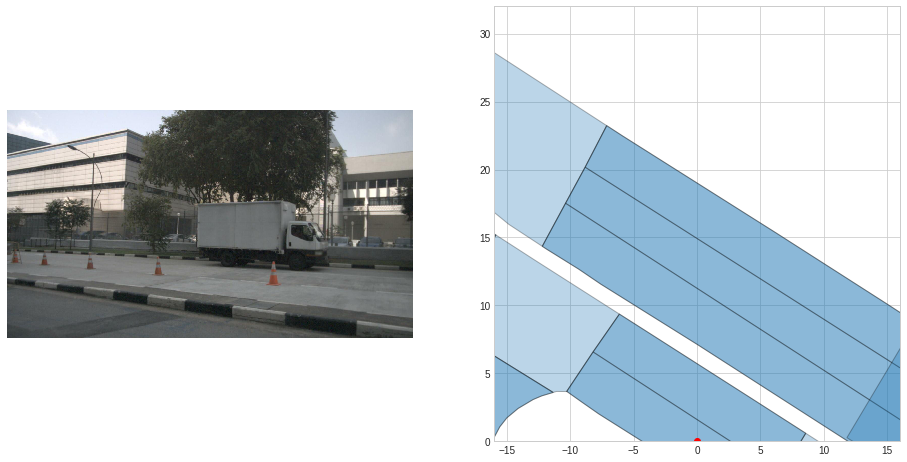

In [4]:
near_plane = 1e-8
render_behind_cam = True

# Init axes.
fig = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim(0., map_size/2.)
ax.set_xlim(-map_size/4., map_size/4.)


cam_frame_points = []

# Retrieve and render each record.
for layer_name in layer_names:
    for token in records_in_patch[layer_name]:
        record = nusc_map.get(layer_name, token)
        
        polygon_tokens = [record['polygon_token']]
        
        for polygon_token in polygon_tokens:
            polygon = nusc_map.extract_polygon(polygon_token)

            # Convert polygon nodes to pointcloud with 0 height.
            points = np.array(polygon.exterior.xy)
            points = np.vstack((points, np.zeros((1, points.shape[1]))))

            # Transform into the ego vehicle frame for the timestamp of the image.
            points = points - np.array(poserecord['translation']).reshape((-1, 1))
            points = np.dot(Quaternion(poserecord['rotation']).rotation_matrix.T, points)

            # Transform into the camera.
            points_cam_coord = points - np.array(cs_record['translation']).reshape((-1, 1))
            points_cam_coord = np.dot(Quaternion(cs_record['rotation']).rotation_matrix.T, points_cam_coord)

            # Remove points that are partially behind the camera.
            points_cam = deepcopy(points_cam_coord)
            depths = points_cam[2, :]
            behind = depths < near_plane

            if render_behind_cam:
                # Perform clipping on polygons that are partially behind the camera.
                points_cam = NuScenesMapExplorer._clip_points_behind_camera(points_cam, near_plane)
            elif np.any(behind):
                # Otherwise ignore any polygon that is partially behind the camera.
                continue

            # Ignore polygons with less than 3 points after clipping.
            if len(points_cam) == 0 or points_cam.shape[1] < 3:
                continue

#             # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
#             points_cam = view_points(points_cam, cam_intrinsic, normalize=True)

#             # Skip polygons where all points are outside the image.
#             # Leave a margin of 1 pixel for aesthetic reasons.
#             inside = np.ones(points_cam.shape[1], dtype=bool)
#             inside = np.logical_and(inside, points_cam[0, :] > 1)
#             inside = np.logical_and(inside, points_cam[0, :] < im.size[0] - 1)
#             inside = np.logical_and(inside, points_cam[1, :] > 1)
#             inside = np.logical_and(inside, points_cam[1, :] < im.size[1] - 1)

#             if np.all(np.logical_not(inside)):
#                 continue

            points = points_cam_coord[[0,2], :]
            points = [(p0, p1) for (p0, p1) in zip(points[0], points[1])]
            polygon_proj = Polygon(points)
            cam_frame_points.append(np.array(points))

            ax.add_patch(descartes.PolygonPatch(polygon_proj, alpha=0.3, label=layer_name))
            
plt.plot(0, 0, 'ro');

In [5]:
def gen_dx_bx_nx(xbound, ybound, zbound):
    dx = np.array([row[2] for row in [xbound, ybound, zbound]])
    bx = np.array([row[0] + row[2]/2.0 for row in [xbound, ybound, zbound]])
    nx = np.array([(row[1] - row[0]) / row[2] for row in [xbound, ybound, zbound]])
    return dx, bx, nx

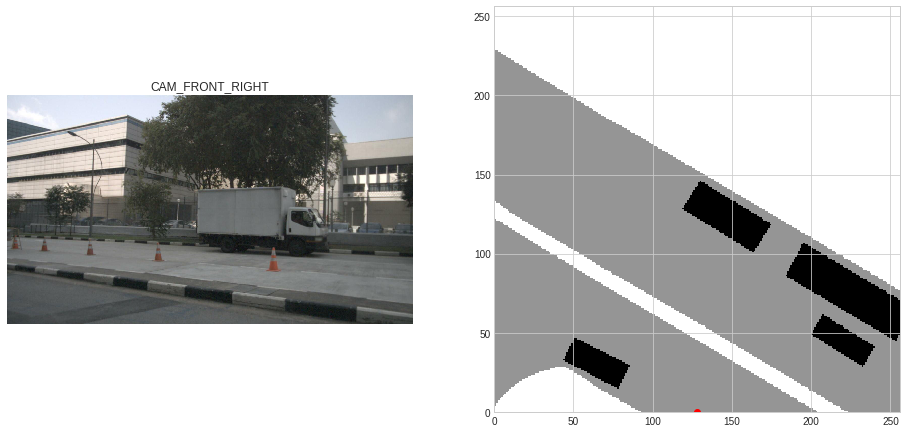

In [6]:
# Fill polygons to construct binary local map
xbound = [-map_size/4., map_size/4., 0.125]
ybound = [0., map_size/2., 0.125]
zbound = [-10.0, 10.0, 20.0]

dx, bx, nx = gen_dx_bx_nx(xbound, ybound, zbound)

local_map = np.zeros(np.array(nx[:2], dtype=np.int))

# add drivable area
for poly_pts in cam_frame_points:
    pts = (poly_pts[:, :2] - bx[:2]) / dx[:2]
    pts = np.round(pts).astype(np.int32)
    #pts[:, [1, 0]] = pts[:, [0, 1]]
    cv2.fillPoly(local_map, [pts], 1.0)

# add cars
for tok in sample_record['anns']:
    inst = nusc.get('sample_annotation', tok)
    # add category for lyft
    if not inst['category_name'].split('.')[0] == 'vehicle':
        continue
    box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
    # transform to ego frame
    box.translate(-np.array(poserecord['translation']))
    box.rotate(Quaternion(poserecord['rotation']).inverse)
    # transform to camera frame
    box.translate(-np.array(cs_record['translation']))
    box.rotate(Quaternion(cs_record['rotation']).inverse)

    pts = box.bottom_corners()[[0,2]].T
    pts = np.round( (pts - bx[:2] + dx[:2]/2.) / dx[:2] ).astype(np.int32)
    cv2.fillPoly(local_map, [pts], 2.0)
    
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.title(camera_channel)
plt.imshow(im)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(local_map)
plt.ylim(0, nx[1])
plt.xlim(0, nx[0])
plt.plot(nx[0]/2., 0, 'ro');

### Dataloader

In [3]:
import sys
sys.path.append('../')
from src.data import NuscData
from src.tools import get_nusc_maps
from src.tools import denormalize_img, normalize_img, img_transform
from src.data import compile_data

import torch
%matplotlib inline

In [4]:
version='mini'
dataroot='/home/ruslan/datasets/nuscenes'
gpuid = 0

H=900
W=1600
final_dim=(256, 704)  # (128, 352)
resize_lim = (0.386, 0.450)  # (0.193, 0.225)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=False
ncams=1

max_grad_norm=5.0
pos_weight=2.13

xbound=[-16.0, 16.0, 0.125]
ybound=[0.0, 32.0, 0.125]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]

grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}

cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT',  'CAM_BACK',  'CAM_BACK_RIGHT']

data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': ncams,
                }


In [5]:
bsz=4
nworkers=10
lr=1e-3
weight_decay=1e-7
nepochs=20

In [6]:
trainloader, valloader = compile_data(version, dataroot, data_aug_conf=data_aug_conf,
                                      grid_conf=grid_conf, bsz=bsz, nworkers=nworkers,
                                      parser_name='segmentationdatamap')

NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.386, 0.45), 'final_dim': (256, 704), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 1}
NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.386, 0.45), 'final_dim': (256, 704), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 1}


torch.Size([1, 3, 256, 704]) torch.Size([2, 256, 256])


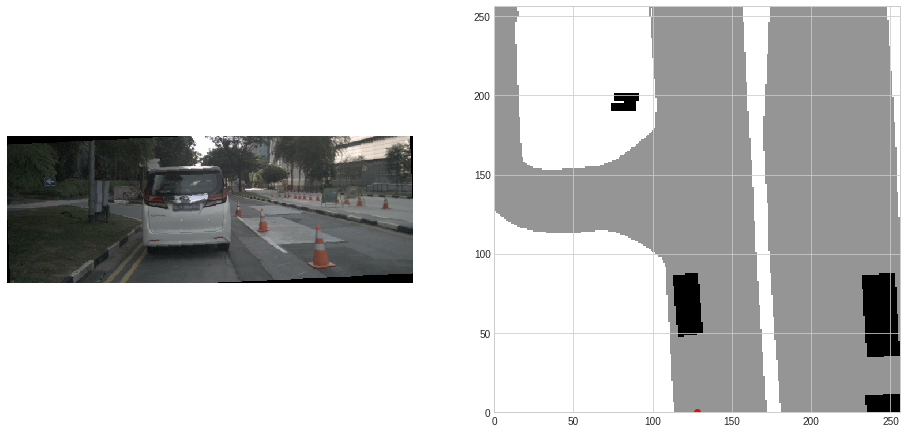

torch.Size([1, 3, 256, 704]) torch.Size([2, 256, 256])


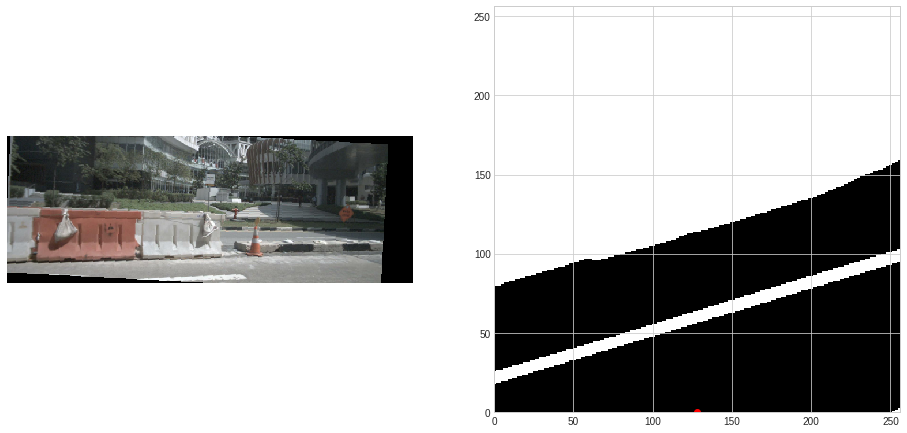

torch.Size([1, 3, 256, 704]) torch.Size([2, 256, 256])


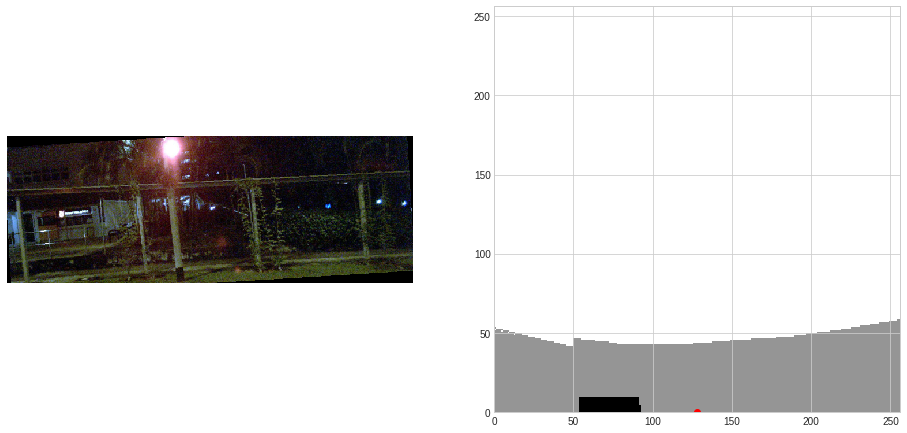

torch.Size([1, 3, 256, 704]) torch.Size([2, 256, 256])


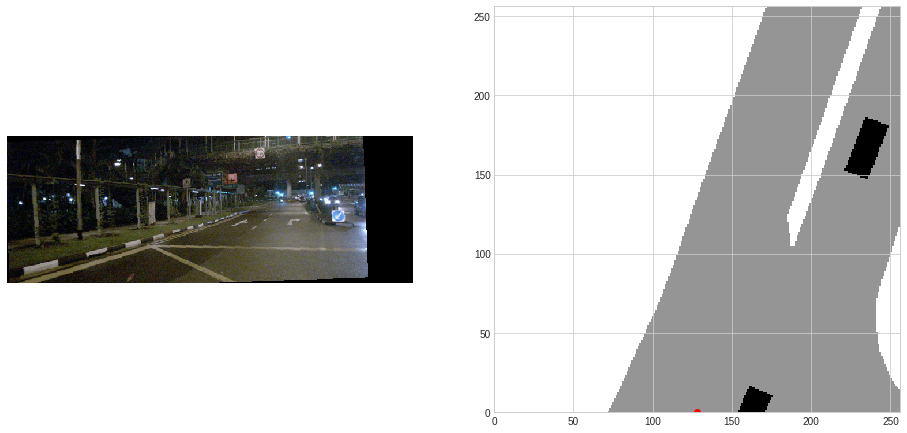

torch.Size([1, 3, 256, 704]) torch.Size([2, 256, 256])


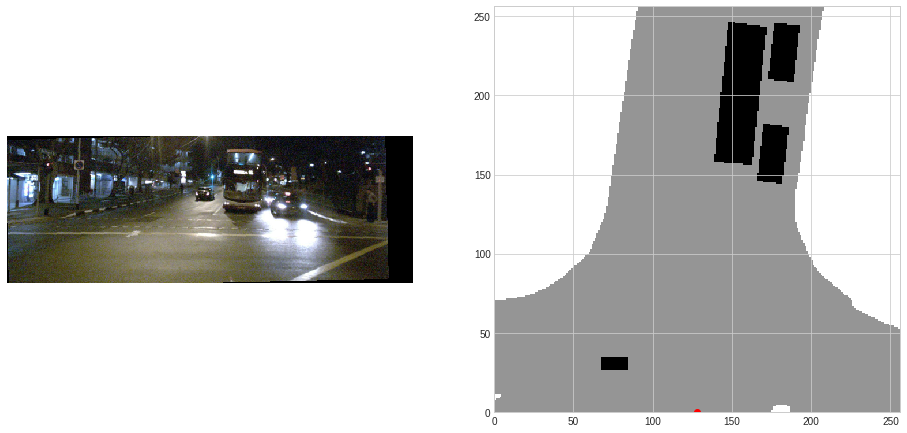

In [7]:
loader = trainloader

for batchi, (imgs, rots, trans, intrins, post_rots, post_trans, map_binimgs) in enumerate(loader):
    if batchi == 5:
        break
    img = imgs[0]
    map_binimg = map_binimgs[0]
    
    print(img.size(), map_binimg.size())
    
    plt.figure(figsize=(16, 8))
    plt.subplot(1,2,1)
    plt.imshow(denormalize_img(img.squeeze(0)))
    plt.axis('off')

    plt.subplot(1,2,2)
    drivable_area = map_binimg[0, ...]
    cars = map_binimg[1, ...]
    local_map = drivable_area.detach().clone()
    local_map[cars.bool()] = 2.
    plt.imshow(local_map.squeeze(0))
    plt.ylim(0, loader.dataset.nx[1])
    plt.xlim(0, loader.dataset.nx[0])
    plt.plot(loader.dataset.nx[0]/2., 0, 'ro')
    plt.show()

### Train

In [8]:
import torch
from time import time
from tensorboardX import SummaryWriter
import numpy as np
import os
from tqdm import tqdm

from src.models import compile_model
from src.tools import SimpleLoss, get_batch_iou, get_val_info

In [9]:
nepochs

20

In [26]:
device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')

model = compile_model(grid_conf, data_aug_conf, outC=2)
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = SimpleLoss(pos_weight).cuda(gpuid)

logdir = f'./runs/lss_{time()}'
writer = SummaryWriter(logdir=logdir)

model.train()

counter = 0

for epoch in tqdm(range(nepochs)):
    np.random.seed()
    for batchi, (imgs, rots, trans, intrins, post_rots, post_trans, binimgs) in enumerate(trainloader):
        t0 = time()
        opt.zero_grad()
        preds = model(imgs.to(device),
                rots.to(device),
                trans.to(device),
                intrins.to(device),
                post_rots.to(device),
                post_trans.to(device),
                )
        binimgs = binimgs.to(device)
        loss = loss_fn(preds, binimgs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()
        counter += 1
        t1 = time()
        
        if counter % 10 == 0:
            print(counter, loss.item())
            writer.add_scalar('train/loss', loss, counter)

        if counter % 50 == 0:
            _, _, iou = get_batch_iou(preds, binimgs)
            writer.add_scalar('train/iou', iou, counter)
            writer.add_scalar('train/epoch', epoch, counter)
            writer.add_scalar('train/step_time', t1 - t0, counter)

        if counter % 50 == 0:
            val_info = get_val_info(model, valloader, loss_fn, device)
            print('VAL', val_info)
            writer.add_scalar('val/loss', val_info['loss'], counter)
            writer.add_scalar('val/iou', val_info['iou'], counter)

        if counter % 50 == 0:
            model.eval()
            mname = os.path.join(logdir, "model{}.pt".format(counter))
            print('saving', mname)
            torch.save(model.state_dict(), mname)
            model.train()

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/20 [00:00<?, ?it/s]

10 0.6820589900016785
20 0.6617911458015442
30 0.6418805122375488
40 0.8216663002967834
50 0.6489560008049011
running eval...
VAL {'loss': 1.1184137051488146, 'iou': 0.4955634869016394, 'iou_static': 0.5310867642130774, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model50.pt
60 0.6073528528213501
70 0.6135677099227905


  5%|▌         | 1/20 [00:38<12:20, 39.00s/it]

80 0.5502090454101562
90 0.6814628839492798
100 0.5278814435005188
running eval...
VAL {'loss': 0.8595608855471198, 'iou': 0.4777385528631207, 'iou_static': 0.5135239869430871, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model100.pt
110 0.6894609332084656
120 0.8215031623840332
130 0.7445613145828247
140 0.538378894329071
150 0.538415789604187
running eval...
VAL {'loss': 0.9593801998797759, 'iou': 0.11510027214127108, 'iou_static': 0.1274986829018283, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model150.pt


 10%|█         | 2/20 [01:22<12:04, 40.25s/it]

160 0.5506665706634521
170 0.5096922516822815
180 0.5834824442863464
190 0.6028538346290588
200 0.6954782009124756
running eval...
VAL {'loss': 0.8119744158085481, 'iou': 0.4890553033841362, 'iou_static': 0.5231317062477278, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model200.pt
210 0.595391035079956
220 0.5844075083732605
230 0.8318754434585571


 15%|█▌        | 3/20 [02:01<11:20, 40.01s/it]

240 0.5618121027946472
250 0.5845696926116943
running eval...
VAL {'loss': 0.8289420707726184, 'iou': 0.5018261570641664, 'iou_static': 0.5383586989415781, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model250.pt
260 0.5394874811172485
270 0.645805835723877
280 0.7582675218582153
290 0.5124231576919556
300 0.6706693768501282
running eval...
VAL {'loss': 0.8128728196944719, 'iou': 0.4974880462813761, 'iou_static': 0.53264965890987, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model300.pt
310 0.6088582277297974


 20%|██        | 4/20 [02:45<10:57, 41.08s/it]

320 0.7455979585647583
330 0.46116864681243896
340 0.47172150015830994
350 0.6229878664016724
running eval...
VAL {'loss': 0.8222340492554653, 'iou': 0.4734400161049391, 'iou_static': 0.5076723136689495, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model350.pt
360 0.7878631949424744
370 0.6267150640487671
380 0.6075695753097534
390 0.5713748931884766
400 0.5398555994033813
running eval...


 25%|██▌       | 5/20 [03:29<10:29, 41.96s/it]

VAL {'loss': 0.8690589931276109, 'iou': 0.46617911623107716, 'iou_static': 0.49943709735864505, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model400.pt
410 0.5976108312606812
420 0.4576377868652344
430 0.5722975134849548
440 0.7760848999023438
450 0.6346212029457092
running eval...
VAL {'loss': 0.8918869333502687, 'iou': 0.4862674083538809, 'iou_static': 0.519550126539232, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model450.pt
460 0.7170546054840088
470 0.6071566343307495


 30%|███       | 6/20 [04:08<09:37, 41.25s/it]

480 0.5570375323295593
490 0.6643224954605103
500 0.5577040910720825
running eval...
VAL {'loss': 0.8398369749387106, 'iou': 0.4849027525861837, 'iou_static': 0.5182055279253124, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model500.pt
510 0.5909029245376587
520 0.8874890804290771
530 0.6244181394577026
540 0.6002984046936035
550 0.6327921152114868
running eval...
VAL {'loss': 0.869341038627389, 'iou': 0.4597136580974111, 'iou_static': 0.4933578311152909, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model550.pt


 35%|███▌      | 7/20 [04:53<09:08, 42.22s/it]

560 0.7402076125144958
570 0.6888266801834106
580 0.5636994242668152
590 0.6120878458023071
600 0.6989783644676208
running eval...
VAL {'loss': 0.8244576196611664, 'iou': 0.5028806271889444, 'iou_static': 0.5391079419739317, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model600.pt
610 0.6453189849853516
620 0.7360401153564453
630 0.6434833407402039


 40%|████      | 8/20 [05:32<08:17, 41.46s/it]

640 0.4766365885734558
650 0.5579652190208435
running eval...
VAL {'loss': 0.8384772428759822, 'iou': 0.4813026543544684, 'iou_static': 0.5211565565924589, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model650.pt
660 0.5798096060752869
670 0.5501705408096313
680 0.7602149248123169
690 0.6471797227859497
700 0.49656733870506287
running eval...
VAL {'loss': 0.9645362812795757, 'iou': 0.20483587454339672, 'iou_static': 0.2240472302317952, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model700.pt
710 0.7136156558990479


 45%|████▌     | 9/20 [06:18<07:48, 42.58s/it]

720 0.5256056785583496
730 0.5848989486694336
740 0.49068886041641235
750 0.6254714727401733
running eval...
VAL {'loss': 1.0268076341829182, 'iou': 0.45876745190290424, 'iou_static': 0.4952249131597313, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model750.pt
760 0.6729933619499207
770 0.809563159942627
780 0.5269209146499634
790 0.613806962966919
800 0.5394725799560547
running eval...


 50%|█████     | 10/20 [07:03<07:14, 43.44s/it]

VAL {'loss': 0.8841710318753748, 'iou': 0.5043153949502682, 'iou_static': 0.5409739336578759, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model800.pt
810 0.5614585280418396
820 0.5448260307312012
830 0.7197723984718323
840 0.7178440093994141
850 0.6364210247993469
running eval...
VAL {'loss': 0.8731765320271622, 'iou': 0.4730211002604273, 'iou_static': 0.5062188136070246, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model850.pt
860 0.5632104277610779
870 0.6186106204986572


 55%|█████▌    | 11/20 [07:44<06:23, 42.62s/it]

880 0.5403247475624084
890 0.6406707763671875
900 0.476267546415329
running eval...
VAL {'loss': 0.8673986873508971, 'iou': 0.48304627220512986, 'iou_static': 0.5177158506832428, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model900.pt
910 0.545976996421814
920 0.6928731799125671
930 0.599543571472168
940 0.5213778018951416
950 0.5206275582313538
running eval...
VAL {'loss': 0.8131226566102769, 'iou': 0.4939668723720819, 'iou_static': 0.5291164292912736, 'iou_dynamic': 3.5775615340583855e-05}
saving ./runs/lss_1607004327.4100146/model950.pt


 60%|██████    | 12/20 [08:29<05:46, 43.33s/it]

960 0.5757785439491272
970 0.6491571664810181
980 0.46450570225715637
990 0.5805479884147644
1000 0.688298225402832
running eval...
VAL {'loss': 0.7959252846093825, 'iou': 0.5029919079766924, 'iou_static': 0.5397904902930326, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1000.pt
1010 0.7982673048973083
1020 0.6386931538581848
1030 0.7537433505058289


 65%|██████▌   | 13/20 [09:10<04:58, 42.68s/it]

1040 0.48706692457199097
1050 0.4732407331466675
running eval...
VAL {'loss': 0.8326598089418293, 'iou': 0.4896037655450756, 'iou_static': 0.5283710665426363, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1050.pt
1060 0.4120614230632782
1070 0.578235387802124
1080 0.731979250907898
1090 0.5597892999649048
1100 0.482763409614563
running eval...
VAL {'loss': 0.8687768019275901, 'iou': 0.5031050000860111, 'iou_static': 0.5396281957381334, 'iou_dynamic': 2.7626140959621634e-06}
saving ./runs/lss_1607004327.4100146/model1100.pt
1110 0.5705965161323547


 70%|███████   | 14/20 [09:56<04:22, 43.80s/it]

1120 0.4232538640499115
1130 0.5076229572296143
1140 0.6003513932228088
1150 0.5635888576507568
running eval...
VAL {'loss': 0.8292057087391983, 'iou': 0.4913983141410553, 'iou_static': 0.5257277437770255, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1150.pt
1160 0.6605464220046997
1170 0.5150270462036133
1180 0.5047175884246826
1190 0.4993492066860199
1200 0.6077232360839844
running eval...


 75%|███████▌  | 15/20 [10:42<03:41, 44.37s/it]

VAL {'loss': 0.941432523874589, 'iou': 0.4879500301800336, 'iou_static': 0.5221924708565651, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1200.pt
1210 0.5403844118118286
1220 0.6397049427032471
1230 0.5349411964416504
1240 0.6867449283599854
1250 0.6178643703460693
running eval...
VAL {'loss': 0.8146695634465159, 'iou': 0.50289908498502, 'iou_static': 0.539132777235203, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1250.pt
1260 0.5350465774536133
1270 0.6721389889717102


 80%|████████  | 16/20 [11:24<02:54, 43.52s/it]

1280 0.4946560263633728
1290 0.5389711856842041
1300 0.534692645072937
running eval...
VAL {'loss': 0.8100823119834617, 'iou': 0.49509706333792386, 'iou_static': 0.5299569888657683, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1300.pt
1310 0.503387451171875
1320 0.6673375964164734
1330 0.6239550113677979
1340 0.4670695662498474
1350 0.5404784083366394
running eval...
VAL {'loss': 0.9085686677767907, 'iou': 0.45995824763485044, 'iou_static': 0.4985283195717937, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1350.pt


 85%|████████▌ | 17/20 [12:09<02:12, 44.15s/it]

1360 0.41684582829475403
1370 0.5257327556610107
1380 0.5194092392921448
1390 0.5387320518493652
1400 0.6490039229393005
running eval...
VAL {'loss': 0.7940076479205379, 'iou': 0.5049414462327024, 'iou_static': 0.5415878676953128, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1400.pt
1410 0.5262625217437744
1420 0.5364153981208801
1430 0.8641061782836914


 90%|█████████ | 18/20 [12:49<01:25, 42.97s/it]

1440 0.3765600621700287
1450 0.5103682279586792
running eval...
VAL {'loss': 0.843467214225251, 'iou': 0.4982921895886615, 'iou_static': 0.5345665034025784, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1450.pt
1460 0.47662249207496643
1470 0.7106097340583801
1480 0.7029114961624146
1490 0.6297231316566467
1500 0.5440313816070557
running eval...
VAL {'loss': 0.8362316224310133, 'iou': 0.4845352218594946, 'iou_static': 0.5177062625193696, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1500.pt
1510 0.7326964139938354


 95%|█████████▌| 19/20 [13:35<00:43, 43.66s/it]

1520 0.5771276950836182
1530 0.6074724197387695
1540 0.4641445279121399
1550 0.5163294076919556
running eval...
VAL {'loss': 0.8665310887642849, 'iou': 0.48915323397992366, 'iou_static': 0.5314317954251735, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1550.pt
1560 0.6759032607078552
1570 0.6714578866958618
1580 0.6662629842758179
1590 0.6707756519317627
1600 0.3866446018218994
running eval...


100%|██████████| 20/20 [14:20<00:00, 43.02s/it]

VAL {'loss': 0.8163477932965314, 'iou': 0.5007763484026965, 'iou_static': 0.5370941711789889, 'iou_dynamic': 0.0}
saving ./runs/lss_1607004327.4100146/model1600.pt
